In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string

### Import ML Lib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
from catboost import CatBoostClassifier
np.__version__

'1.26.4'

In [7]:
# Check accuracy and scores of the models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score

### Import data

In [13]:
fake = pd.read_csv("data/input/fake-news-detection/Fake.csv")
true = pd.read_csv("data/input/fake-news-detection/True.csv")
print('Fake news data: ',fake.shape)
print('True news data:',true.shape)

Fake news data:  (23481, 4)
True news data: (21417, 4)


### Preview data

In [14]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [15]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Creating a new column for making fake and true news

In [19]:
fake['class'] = 0
true['class'] = 1

### Combining two data to one data

In [31]:
data = pd.concat([fake, true], axis=0)
data

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


### Shuffling data

In [32]:
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True) 
data.head()

,title,text,subject,date,class
0,Tom Cotton Accepted $1 Million From Israel To...,How much money does it take for a foreign nati...,News,"January 4, 2016",0
1,VIOLENT NPR EMPLOYEE Who Is Also A Refugee ARR...,On Monday Politico reported that a protester w...,politics,"Feb 14, 2017",0
2,WHAT THE MAINSTREAM MEDIA WON’T SHOW YOU: NEW ...,The mainstream media will never show you both ...,left-news,"Jul 21, 2017",0
3,World Food Programme cuts rations for refugees...,NAIROBI (Reuters) - The U.N. World Food Progra...,worldnews,"October 2, 2017",1
4,Trump's trade czar expected to get easy U.S. S...,WASHINGTON (Reuters) - Billionaire investor Wi...,politicsNews,"February 27, 2017",1


### Removing unwanted data before training ML models

In [34]:
data = data.drop(['title', 'subject', 'date'], axis=1)
data.head()

,text,class
0,How much money does it take for a foreign nati...,0
1,On Monday Politico reported that a protester w...,0
2,The mainstream media will never show you both ...,0
3,NAIROBI (Reuters) - The U.N. World Food Progra...,1
4,WASHINGTON (Reuters) - Billionaire investor Wi...,1


### Modifying news texts by removing unnecessary words and other characters

In [35]:
def process_news(text):
    text = text.lower()
    text = re.sub(r'https?://S+ | www\.\S+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub('\[.*?\]', '', text)
    words=[]
    for i in text:
        if i not in string.punctuation:
            words.append(i)
    return ''.join(words)


data['text'] = data['text'].apply(process_news)
data['text'].head()

<>:5: SyntaxWarning: invalid escape sequence '\['
<>:5: SyntaxWarning: invalid escape sequence '\['
/var/folders/z6/2wz7jxb56936gt0mxv3lscnm0000gn/T/ipykernel_16250/2222153220.py:5: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)


0    how much money does it take for a foreign nati...
1    on monday politico reported that a protester w...
2    the mainstream media will never show you both ...
3    nairobi reuters  the un world food programme i...
4    washington reuters  billionaire investor wilbu...
Name: text, dtype: object

In [46]:
### Separating the data 80:20 for training and testing
x = data['text']
y = data['class']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
xtest

11434    anyone trying to defend donald trump after his...
27113    washington reuters  the pentagon said on tuesd...
37786                    httpswwwyoutubecomwatchvfnt3nsega
34370    havana reuters  an association of cuban busine...
31614    remember when chelsea clinton faced the same s...
                               ...                        
42715    washington reuters  republican us senator rob ...
6589     of course the government will have to address ...
4467     paris reuters  france’s farright national fron...
5509     beijing reuters  some top chinese officials ar...
21334    washington reuters  obama’s trip to flint mich...
Name: text, Length: 8980, dtype: object

### Before training, converting text to vector form

In [47]:
vector = TfidfVectorizer()
xtrain = vector.fit_transform(xtrain)
xtest = vector.transform(xtest)

### Creating a set of models

In [48]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
#     'K-NN': KNeighborsClassifier(),  # This will take too much time, it best not to use this method
#     'SVM': SVC(),  # It also take around additional 30min to run
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0,loss_function='Logloss', random_seed=42),
    'Gradient Classifier' : GradientBoostingClassifier(random_state=0)
}

In [49]:
import time

### Training every model from the set and testing their accuracy

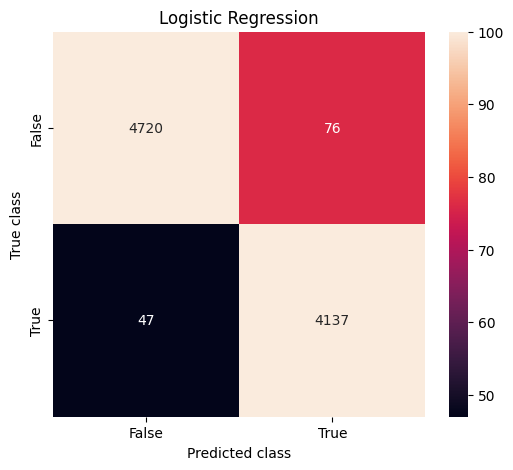

Accuracy:  0.9863028953229399
Precision:  0.9819605981485877
Recall:  0.9887667304015296
F1-Score:  0.9853519113969275
Matthews correlation coefficient:  0.972510583465498
Time taken(in sec):  2.57
---------------------------------------------------------------------- 



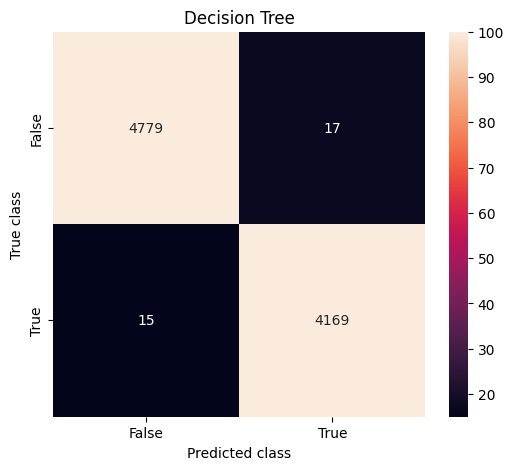

Accuracy:  0.9964365256124722
Precision:  0.9959388437649307
Recall:  0.996414913957935
F1-Score:  0.9961768219832736
Matthews correlation coefficient:  0.9928401125747094
Time taken(in sec):  50.31
---------------------------------------------------------------------- 



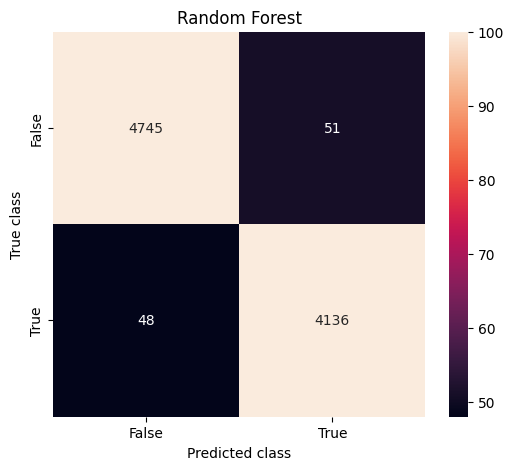

Accuracy:  0.9889755011135858
Precision:  0.9878194411272988
Recall:  0.988527724665392
F1-Score:  0.988173455978975
Matthews correlation coefficient:  0.9778493487916622
Time taken(in sec):  137.39
---------------------------------------------------------------------- 



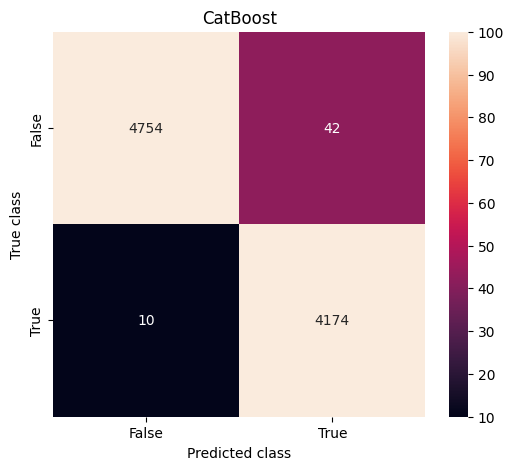

Accuracy:  0.9942093541202672
Precision:  0.9900379506641366
Recall:  0.9976099426386233
F1-Score:  0.9938095238095238
Matthews correlation coefficient:  0.9883956539766474
Time taken(in sec):  109.88
---------------------------------------------------------------------- 



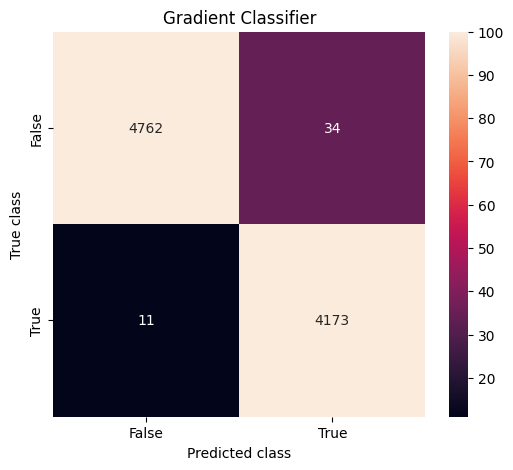

Accuracy:  0.994988864142539
Precision:  0.9919182315188971
Recall:  0.9973709369024857
F1-Score:  0.9946371111905613
Matthews correlation coefficient:  0.989947592227442
Time taken(in sec):  348.29
---------------------------------------------------------------------- 



In [50]:
for name, model in models.items():
    start = time.time()
    model.fit(xtrain, ytrain)
    predict = model.predict(xtest)
    
    LABELS = ['False', 'True']
    conf_matrix = confusion_matrix(ytest, predict)
    plt.figure(figsize =(6,5))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, vmax = 100, annot = True, fmt ="d");
    plt.title(f'{name}')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print("Accuracy: ", accuracy_score(ytest, predict))
    print("Precision: ", precision_score(ytest, predict))
    print("Recall: ", recall_score(ytest, predict))
    print("F1-Score: ", f1_score(ytest, predict))
    print("Matthews correlation coefficient: ", matthews_corrcoef(ytest, predict))
    end = time.time()
    print("Time taken(in sec): ",round(end-start, 2))
    print('-' * 70, '\n')